In [3]:
%load_ext autoreload
%autoreload 2

# Make sure the project root is in Python path
import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm

In [6]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

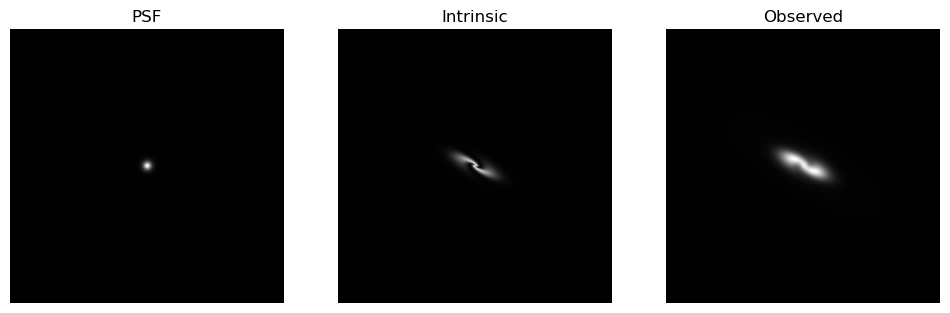

In [7]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [8]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 15, 15)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the rescaled weight function
weight_rescale = wiener_deconvolution(weight, image_psf, 0)

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F = np.sum(weight_rescale * image)
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.339277
The aperture flux using the observed image and rescaled weight function : 0.338157


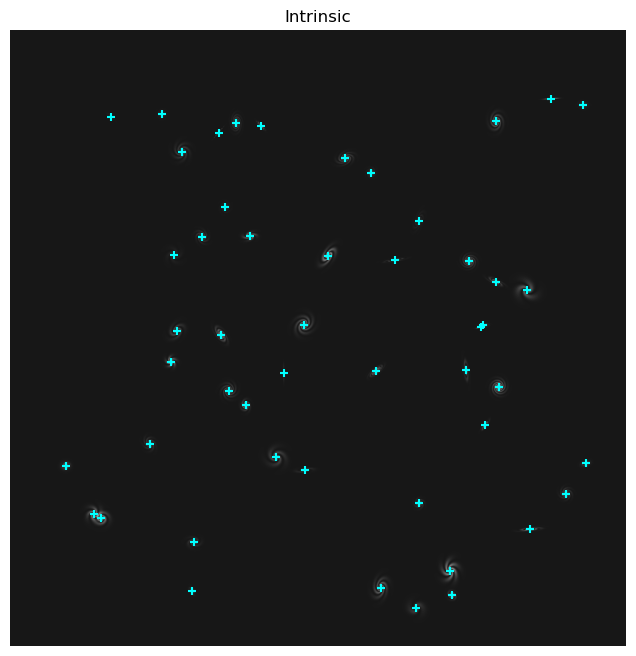

In [9]:
N_galaxies = 50
height = 1000
width = 1000
margin = 50

# Define scaling for the weight
a = 8
b = 8

image = np.zeros((height, width), dtype=float)

centers = []
true_F = []
for _ in range(N_galaxies):
    # Generate random galaxy parameters
    xc = int(np.random.uniform(0 + margin, width - margin))
    yc = int(np.random.uniform(0 + margin, height - margin))
    k = np.random.uniform(1e-3, 1)
    n = np.random.uniform(0.2, 0.5)
    rotation = np.random.uniform(-np.pi / 2, np.pi / 2)
    inclination = np.random.uniform(0.1, np.pi / 2)
    n_arms = np.random.randint(2, 6)
    winding = np.random.uniform(1, 5)
    arm_width = np.random.uniform(0.001, 0.004)
    bulge_strength = np.random.uniform(0.5, 1)
    Rc = np.random.uniform(5, 15)

    # Generate galaxy image
    galaxy_image = sersic(height, width, xc, yc, k, n, inclination=inclination, rotation=rotation, Rc=Rc, n_arms=n_arms,
                          winding=winding, bulge_strength=bulge_strength,
                          direction=np.random.choice([-1, 1])) * np.random.uniform(1, 10)

    # Store galaxy center and true flux
    centers.append((xc, yc))
    weight = gaussian_weight(height, width, xc, yc, a, b)
    true_F.append(np.sum(weight * galaxy_image))

    # Add galaxy image to the total image
    image += galaxy_image

# Plot intrinsic image
plt.figure(figsize=(8, 8))
for (xc, yc) in centers:
    plt.scatter(xc, yc, c='cyan', marker='+')
plt.imshow(image)
plt.title("Intrinsic")
plt.show()

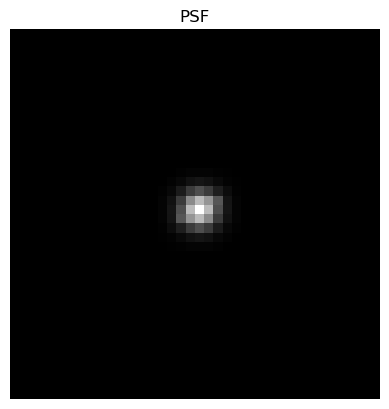

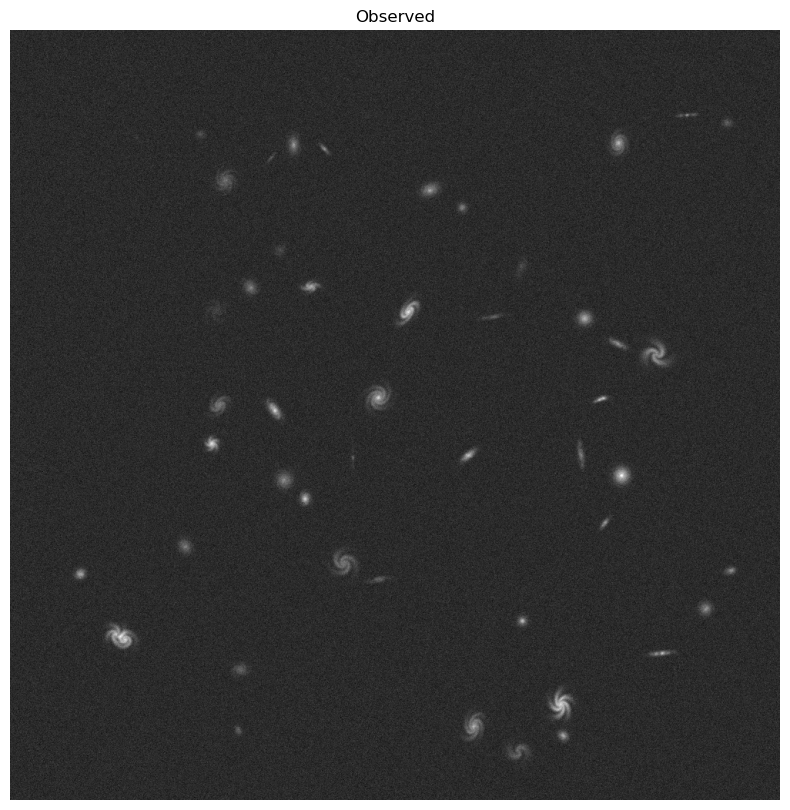

In [12]:
# Define normalized PSF
image_psf = moffat(40, 40, 8, 5, n_spikes=2, rotation=np.pi/3, spike_strength=0.2, spike_width=0.2, Rc=2)
image_psf /= image_psf.sum()

# Plot PSF
plt.imshow(image_psf)
plt.title("PSF")
plt.show()

# Add noise and convolve with PSF
sigma = 0.5
noise = np.random.normal(0, sigma, size=image.shape)
new_image = fftconvolve(image, image_psf, mode='same') + noise

# Plot convolved image with noise
plt.figure(figsize=(10, 10))
plt.imshow(new_image)
plt.title("Observed")
plt.show()

In [11]:
weight = gaussian_weight(height, width, height / 2, width / 2, a, b)
weight_rescale = wiener_deconvolution(weight, image_psf, 0)
F_map = fftconvolve(new_image, weight_rescale[::-1, ::-1], mode='same')
measured_F = []
for i, (xc, yc) in enumerate(centers):

    # Calculate the aperture flux using the observed image and rescaled weight function
    measured_F.append(F_map[int(round(yc)), int(round(xc))])

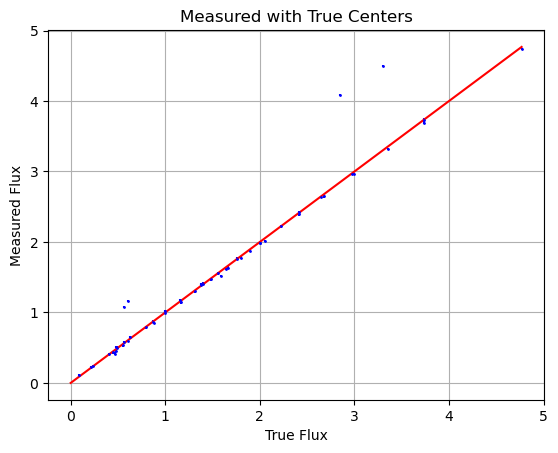

In [13]:
measured_F = np.array(measured_F)
true_F = np.array(true_F)

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot measured flux vs true flux
    plt.errorbar(true_F, measured_F, yerr=np.sqrt(np.sum(weight_rescale**2)*sigma**2), label='Measured', c='blue', fmt='o', ms=1)
    plt.plot(np.linspace(0, max(true_F), 10), np.linspace(0, max(true_F), 10), c='red', label='True')

    plt.title("Measured with True Centers")
    plt.xlabel('True Flux')
    plt.ylabel('Measured Flux')
    plt.show()


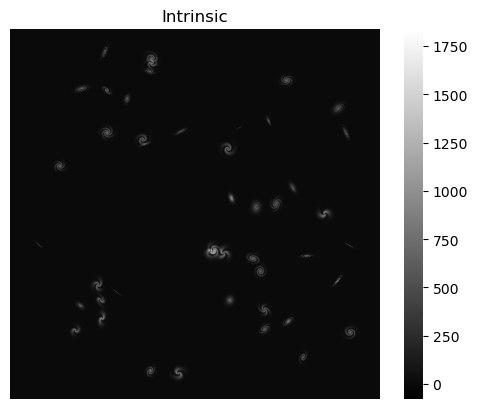

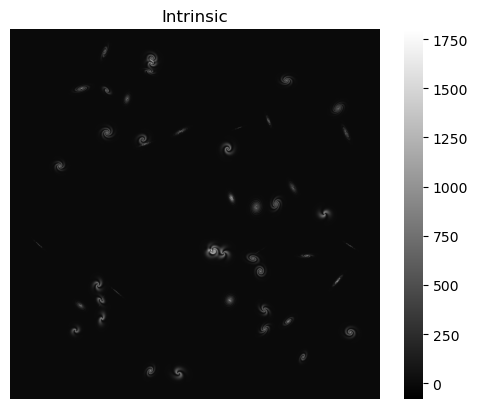

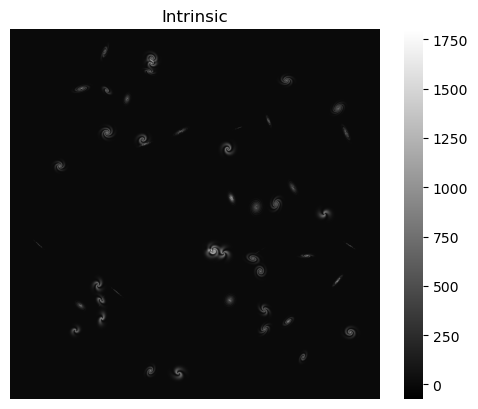

In [14]:
N_galaxies = 50
height = 1000
width = 1000
margin = 50

# Define scaling for the weight
a = 10
b = 10

images = np.zeros((3, height, width), dtype=float)

random_intensity = np.vstack([abs(np.random.normal(500, 20, size=(N_galaxies, 3))),
                            abs(np.random.normal(1000, 80, size=(N_galaxies, 3))),
                            abs(np.random.normal(2000, 40, size=(N_galaxies, 3)))])


centers = []
true_F = np.zeros_like(random_intensity)
for i in range(N_galaxies):
    # Generate random galaxy parameters
    xc = np.random.uniform(0 + margin, width - margin)
    yc = np.random.uniform(0 + margin, height - margin)
    k = np.random.uniform(1e-3, 1)
    n = np.random.uniform(0.2, 0.5)
    rotation = np.random.uniform(-np.pi / 2, np.pi / 2)
    inclination = np.random.uniform(0.1, np.pi / 2)
    n_arms = np.random.randint(2, 6)
    winding = np.random.uniform(1, 5)
    arm_width = np.random.uniform(0.001, 0.004)
    bulge_strength = np.random.uniform(0.5, 1)
    Rc = np.random.uniform(10, 15)

    # Generate galaxy image
    galaxy_image = sersic(height, width, xc, yc, k, n, inclination=inclination, rotation=rotation, Rc=Rc, n_arms=n_arms,
                          winding=winding, bulge_strength=bulge_strength,
                          direction=np.random.choice([-1, 1]))

    # Store galaxy center and true flux
    weight = gaussian_weight(height, width, xc, yc, a, b)
    for j, intensity in enumerate(random_intensity[i]):
        true_F[i, j] = np.sum(weight * galaxy_image * intensity)

        # Add galaxy image to the total image
        images[j] += galaxy_image * intensity
    centers.append((xc, yc))

for i in range(3):
    plt.imshow(images[i])
    plt.colorbar()
    plt.title("Intrinsic")
    plt.show()

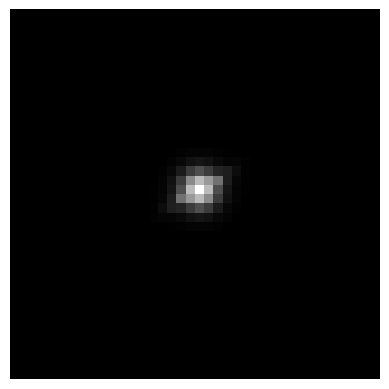

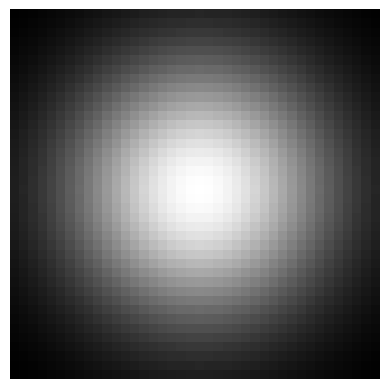

In [15]:
plt.imshow(moffat(40, 40, 8, 5, n_spikes=2, rotation=np.pi/3, spike_strength=0.2, spike_width=0.2, Rc=3))
plt.show()
plt.imshow(gaussian_weight(40, 40, 40 / 2, 40 / 2, a, b))
plt.show()

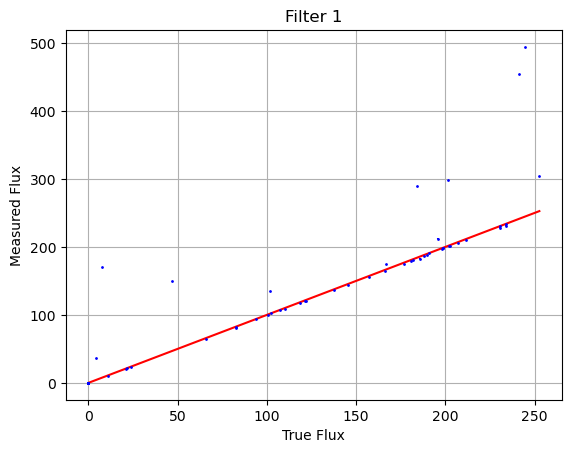

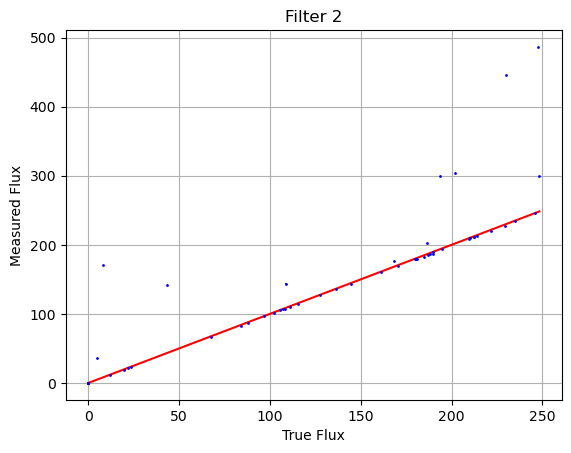

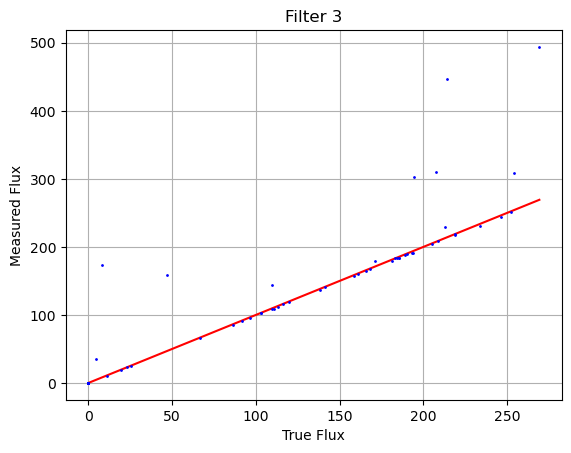

In [16]:
noise_strengths = [5, 2, 1]
measured_F = np.zeros_like(true_F)
sigma = np.zeros_like(noise_strengths)
for i, image in enumerate(images):
    image_psf = moffat(40, 40, 8, 5, n_spikes=2, rotation=np.pi/3, spike_strength=0.2, spike_width=0.2, Rc=3)
    image_psf /= image_psf.sum()
    noise = np.random.normal(0, noise_strengths[i], size=image.shape)
    new_image = fftconvolve(image, image_psf, mode='same') + noise

    x = new_image[new_image<0].flatten()

    n = len(x)
    S = np.sum(x**2)

    # Posterior for tau = sigma^2 is Inv-Gamma(a=n/2, scale=beta=S/2)
    alpha = n / 2.0
    beta = S / 2.0

    # point estimates
    sigma[i] = np.sqrt(beta / (alpha + 1)) 
    # Calculate rescaled weight
    weight = gaussian_weight(height, width, height / 2, width / 2, a, b)
    weight_rescale = wiener_deconvolution(weight, image_psf, 0)
    F_map = fftconvolve(new_image, weight_rescale[::-1, ::-1], mode='same')
    for j, (xc, yc) in enumerate(centers):

        # Calculate the aperture flux using the observed image and rescaled weight function
        measured_F[j, i] = F_map[int(round(yc)), int(round(xc))]

for i in range(3):
    with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
    }):
        # Plot measured flux vs true flux
        plt.errorbar(true_F[:, i], measured_F[:, i], yerr=np.sqrt(np.sum(weight_rescale**2)*sigma[i]**2), label='Measured', c='blue', fmt='o', ms=1)
        plt.plot(np.linspace(0, max(true_F[:, i]), 10), np.linspace(0, max(true_F[:, i]), 10), c='red', label='True')

        plt.title(f"Filter {i+1}")
        plt.xlabel('True Flux')
        plt.ylabel('Measured Flux')
        plt.show()

/var/tmp/deklerk/ipykernel_3014996/2798669209.py:9: RuntimeWarning: invalid value encountered in divide
  y_color = -2.5 * np.log10(measured_F[:, 0]/measured_F[:, 1])
/var/tmp/deklerk/ipykernel_3014996/2798669209.py:9: RuntimeWarning: invalid value encountered in log10
  y_color = -2.5 * np.log10(measured_F[:, 0]/measured_F[:, 1])
/var/tmp/deklerk/ipykernel_3014996/2798669209.py:10: RuntimeWarning: invalid value encountered in divide
  x_color = -2.5 * np.log10(measured_F[:, 1]/measured_F[:, 2])
/var/tmp/deklerk/ipykernel_3014996/2798669209.py:10: RuntimeWarning: invalid value encountered in log10
  x_color = -2.5 * np.log10(measured_F[:, 1]/measured_F[:, 2])
/var/tmp/deklerk/ipykernel_3014996/2798669209.py:11: RuntimeWarning: divide by zero encountered in divide
  yerr = 2.5/np.log(10)*np.sqrt((sigma[0]/measured_F[:, 0])**2+(sigma[1]/measured_F[:, 1])**2)
/var/tmp/deklerk/ipykernel_3014996/2798669209.py:12: RuntimeWarning: divide by zero encountered in divide
  xerr = 2.5/np.log(10)*n

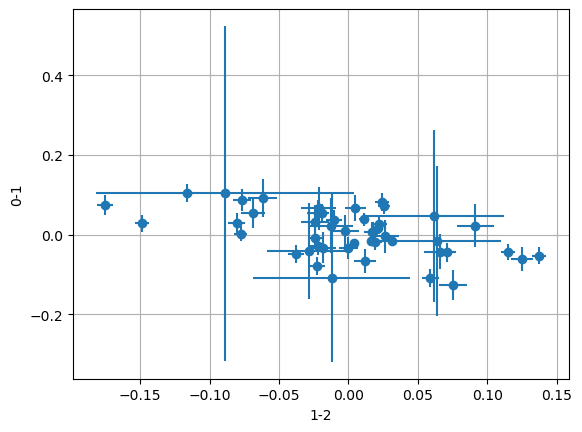

In [17]:
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
    }):
    y_color = -2.5 * np.log10(measured_F[:, 0]/measured_F[:, 1])
    x_color = -2.5 * np.log10(measured_F[:, 1]/measured_F[:, 2])
    yerr = 2.5/np.log(10)*np.sqrt((sigma[0]/measured_F[:, 0])**2+(sigma[1]/measured_F[:, 1])**2)
    xerr = 2.5/np.log(10)*np.sqrt((sigma[1]/measured_F[:, 1])**2+(sigma[2]/measured_F[:, 2])**2)
    plt.errorbar(x_color, y_color, xerr=xerr, yerr=yerr, fmt='o')
    plt.xlabel('1-2')
    plt.ylabel('0-1')
    plt.show()